## MNIST 손글씨 예측하기

---



In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# MNIST 이미지 사이즈 = 28X28X1
input_size=784
# hidden layer의 unit의 개수 : 784개의 특징을 500개의 unit으로 압축
hidden_size=500
# 최종 출력되는 카테고리의 수
num_class=10
num_epoch=5
# 한번 로딩할 때 불러오는 사진의 픽셀 개수

batch_size=100
learning_rate=0.001

In [ ]:
train_set=torchvision.datasets.MNIST(root="../python_workshop/data/",
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)
test_set=torchvision.datasets.MNIST(root="../python_workshop/data/",
                                    train=False,
                                    transform=transforms.ToTensor
# ToTensor 기능
'''
1) 데이터 타입을 텐서로 만들기
2) Scaling : (0부터 255사이의 값을)255로 나눠준다
- 분산을 작게하려고 = 오버피팅을 작게 하려고 = 예측값을 smooth하게 만들어 줌
3) 채널을 맨 뒤로 보낸다. 차원을 바꿔줌...(3,32,32) >> (32,32,3)
'''

In [1]:
# 물리적 위치에 저장하고 scaling한 데이터 train_set를 batch_size단위만큼 읽으면서 학습 진행
# 5만장을 64개씩 불러오니까 781회 실행
# DataLoader는 멀티스레딩 방식으로 랩핑되어 있어 클래스를 빠르게 로딩
# batch_size 개수만큼 100개씩 로딩함
# shuffle=100으로 모델이 답지를 외우는 경우를 방지
train_loader=torch.utils.data.DataLoader(dataset=train_set,
                                        batch_size=batch_size,# 마지막에 남은 값을 버리지 않고 돌린다
                                        shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_set,
                                        batch_size=batch_size,
                                        shuffle=False)
# batch_size
'''
1) 연산의 성능에 영향을 준다
2) 6만번 학습 후 1번 채점하는 코드를 600번 학습하고 600번 채점하는 것으로 바꿔줌 >> 성능 향상
'''


NameError: ignored

## 모델 생성하기 : Fully Connected Network
    Fully Connected Network : 이미지 정보를 1열의 vector로 펼쳐서 넣음
    따라서 원래 데이터에 있는 공간정보가 사라짐


In [ ]:
class NeuralNet(nn.Module): # nn.Module을 상속받아서 만들어진다. 
  def __init__(self,input_size,hidden_size,num_classes): # 클래스 초기화 함수
    super(NeuralNet, self).__init__()
    self.fc1=nn.Linear(input_size,hidden_size) # 하나의 레이어가 생성. nn.Linear(x,y) y는 다음 hidden Layer의 x가 된다.
    self.relu=nn.ReLU() # 활성함수
    self.fc2=nn.Linear(hidden_size,num_classes)
  def forward(self, x):
    out=self.fc1(x)
    out=self.relu(out)
    out=self.fc2(out)
    return out # 여기까지가 클래스 정의 부분.

### 인스턴스화

In [ ]:
model=NeuralNet(input_size,hidden_size,num_class).to(device)
loss_function=nn.CrossEntropyLoss() # 미리 정의
# loss 값을 찾는데 사용하는 CrossEntropyLoss... CrossEntropyLoss함수 자체에 소프트 맥스 포함함
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # 선정의  | 학습을 어떻게 할지
total_step = len(train_loader) # 트레이닝 데이터가 6만개인데 batch사이즈를 100으로 하였음. 60000 / 100으로 출력된다.
for epoch in range(num_epoch): # 5
  for i, (images, labels) in enumerate(train_loader): # train_loader 100개씩 로더
    # 이미지랑 라벨이랑 묶어서 반환 (for 문 한번 돌때 마다 100장씩 로딩)
    images=images.reshape(-1,28*28).to(device)
    labels=labels.to(device) # 정답값
    # -1은 28,28을 제외한 나머지 정보들을 -1로 바꾼다.
    # forward
    preds=model(images)     # model.farward(images) 와 같음. 앞서 정의한 모델을 여기서 호출 
    loss=loss_function(preds,labels) # 두 라벨을 비교하고 loss를 구한다.
    # backward
    optimizer.zero_grad() # backward 하기전에 무조건 초기화해야한다.
    loss.backward() # 각각의 weight들이 loss에 대해서 얼마나 책임져야하는지 정량화.
    optimizer.step() # 학습시키기 | 실질적인 weight들의 업데이트가 진행된다. (학습)

    if(i+1)%100==0:
      print('Epoch[{}/{}], Step:[{}/{}], Loss:{:.3f}'.format(epoch+1,num_epoch,i+1,total_step,loss.item()))

## Model Test
    - test시 역전파와 기울기를 구하는 옵션을 꺼줘야 메모리를 할당하지 않게 함. 따라서 메모리 측면에서 효율적

    - Fully Connected NN은 CNN과 비교하여 효율면에서 떨어짐.
    그래서 Fully Connected는 CPU에서 동작X, GPU도 성능이 좋아야 가능.
    요즘은 CNN만 쓰고,연산이 많은 Fully Connected는 부분적으로만 사용함.

In [ ]:
with torch.no_grad():
    # test 데이터는 gradient,backpropagation 사용하지 않음.
    # 위와 같이 설정해야 Backward연산을 위한 메모리를 따로 할당하지 않아서 성능이 향상됨
    '''
    위와 같은 표현
    with torch.grad_enabled(False):
        ....
    '''
    correct=0
    total=0
    for images,labels in test_loader:
        images=images.reshape(-1,28*28).to(device)
        labels=labels.to(device)

        outputs=model(images)
        _,predicted=torch.max_output=torch.max(outputs.data,1)    
        # 80,3 우리는 value인 80말고 label인 3만 있으면됨.
        # python에서는 _ 로 값을 안 받음을 표시

        total+=labels.size(0)   #0 안해주면 100 안 나옴
        correct+=(predicted==labels).sum().item()
        # 위의 코드는 정확하게 예측한 것은 1,틀리면 0으로 표시하고 1값을 모두 더해서 맞춘 개수를 출력
    print("Accuracy of the FCN | {}%".format(100*correct/total))

torch.save(model.state_dict(),"model.ckpt") # 모델의 학습 주체인 weight,bias를 저장

Accuracy of the FCN | 99.29166666666667%


In [ ]:
images.shape
# torch.Size([100, 784]) >> 100은 배치사이즈 100장을 의미

torch.Size([100, 784])

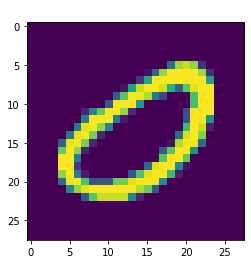

In [ ]:
plt.imshow(images[1].cpu().reshape(28,28).numpy())
plt.title(outputs[1].argmax(),color="white")
plt.show()

In [ ]:
outputs.shape
# torch.Size([100, 10]) >> 100장의 batch사이즈, 10개 카테고리의 예측값 

torch.Size([100, 10])

tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(5, device='cuda:0')
tensor(6, device='cuda:0')
tensor(7, device='cuda:0')
tensor(8, device='cuda:0')


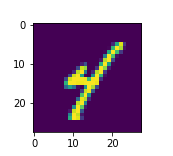

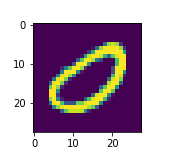

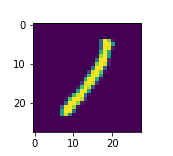

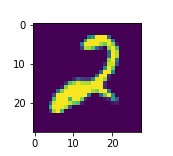

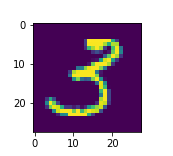

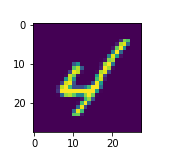

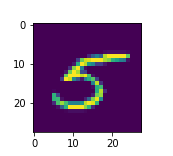

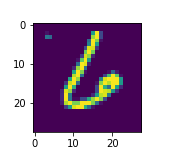

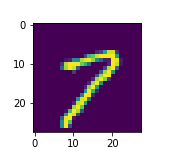

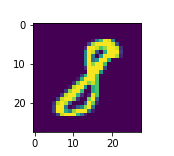

In [ ]:
for i in range(10):
    plt.figure(figsize=(2,2))
    plt.imshow(images[i].cpu().reshape(28,28).numpy())
    plt.title(outputs[i].argmax(),color="white")
    print(outputs[i].argmax())